In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math

2024-01-30 22:21:58.688570: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 22:21:58.688612: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 22:21:58.692589: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 22:21:58.979621: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_file = "./train.tsv"
test_file = "./test.tsv"

train_data = pandas.read_csv(train_file, delimiter='\t').to_numpy()
train_data2 = np.empty((train_data.shape[0], train_data.shape[1]-2))
train_data2[:, 0:] = train_data[:, 2:]
train_data2[:,0:1] = train_data2[:,0:1] / 4.0   #季節を0～1に正規化
train_data2[:,2:3] = train_data2[:, 2:3] / 6.0 #月を0～1に正規化
train_data2[:,3:4] = train_data2[:, 3:4] / 11.5 #時間を0～1に正規化
train_data2[:,5:6] = train_data2[:,5:6] / 6.0   #曜日を0～1に正規化
train_data2[:,7:8] = train_data2[:,7:8] / 4.0   #天気を0～1に正規化
train_data2 = train_data2#.astype(np.float32)
rnd = np.random.default_rng()
rnd.shuffle(train_data2,axis=0)

test_data = pandas.read_csv(test_file, delimiter='\t').to_numpy()
test_data2 = np.empty((test_data.shape[0], test_data.shape[1]-2))
test_data2[:, 0:] = test_data[:, 2:]
test_data2[:,3:4] = test_data2[:, 3:4] / 12.0 #月を0～1に正規化
test_data2[:,5:6] = test_data2[:,5:6] / 6.0   #曜日を0～1に正規化
test_data2[:,7:8] = test_data2[:,7:8] / 4.0   #天気を0～1に正規化
test_data2 = test_data2.astype(np.float32)

display(train_data2)
display(test_data2)

x = train_data2[:, 12:]
x = x.reshape(x.shape[0], 1)
#print(x)
y = train_data2[:, :12]
y = y.reshape(y.shape[0], y.shape[1],1)
#print(y)
test_y = test_data2.reshape(test_data2.shape[0], test_data2.shape[1], 1)

array([[1.00000000e+00, 0.00000000e+00, 2.00000000e+00, ...,
        6.20000000e-01, 1.34300000e-01, 3.23000000e+02],
       [1.00000000e+00, 0.00000000e+00, 1.83333333e+00, ...,
        9.40000000e-01, 8.96000000e-02, 4.36000000e+02],
       [7.50000000e-01, 0.00000000e+00, 1.00000000e+00, ...,
        7.40000000e-01, 0.00000000e+00, 1.30000000e+01],
       ...,
       [2.50000000e-01, 0.00000000e+00, 1.66666667e-01, ...,
        5.50000000e-01, 0.00000000e+00, 1.10000000e+01],
       [5.00000000e-01, 0.00000000e+00, 1.00000000e+00, ...,
        5.40000000e-01, 0.00000000e+00, 4.17000000e+02],
       [7.50000000e-01, 0.00000000e+00, 1.50000000e+00, ...,
        6.50000000e-01, 0.00000000e+00, 2.99000000e+02]])

array([[ 1.    ,  1.    ,  1.    , ...,  0.3788,  0.66  ,  0.    ],
       [ 1.    ,  1.    ,  1.    , ...,  0.3485,  0.66  ,  0.1343],
       [ 1.    ,  1.    ,  1.    , ...,  0.3485,  0.76  ,  0.    ],
       ...,
       [ 1.    ,  1.    , 12.    , ...,  0.2576,  0.6   ,  0.1642],
       [ 1.    ,  1.    , 12.    , ...,  0.2727,  0.56  ,  0.1343],
       [ 1.    ,  1.    , 12.    , ...,  0.2727,  0.65  ,  0.1343]],
      dtype=float32)

In [17]:
tokyo_file = "./test_local_tokyo.tsv"
tokyo_data = pandas.read_csv(tokyo_file, delimiter='\t').to_numpy()
tokyo_data2 = np.empty((tokyo_data.shape[0], tokyo_data.shape[1]-2))
tokyo_data2[:, 0:] = tokyo_data[:, 2:]
tokyo_data2[:,0:1] = tokyo_data2[:,0:1] / 4.0   #季節を0～1に正規化
tokyo_data2[:,2:3] = tokyo_data2[:, 2:3] / 6.0 #月を0～1に正規化
tokyo_data2[:,3:4] = tokyo_data2[:, 3:4] / 11.5 #時間を0～1に正規化
tokyo_data2[:,5:6] = tokyo_data2[:,5:6] / 6.0   #曜日を0～1に正規化
tokyo_data2[:,7:8] = tokyo_data2[:,7:8] / 4.0   #天気を0～1に正規化
tokyo_data2 = tokyo_data2.astype(np.float32)
tokyo_y = tokyo_data2.reshape(tokyo_data2.shape[0], tokyo_data2.shape[1], 1)
display(tokyo_data2)

array([[0.25      , 0.        , 0.16666667, ..., 0.33424816, 0.4       ,
        0.516129  ],
       [0.25      , 0.        , 0.16666667, ..., 0.32986692, 0.41      ,
        0.39784947],
       [0.25      , 0.        , 0.16666667, ..., 0.32986692, 0.4       ,
        0.37634408],
       ...,
       [0.25      , 0.        , 2.        , ..., 0.44377908, 0.69      ,
        0.15053764],
       [0.25      , 0.        , 2.        , ..., 0.42625412, 0.74      ,
        0.10752688],
       [0.25      , 0.        , 2.        , ..., 0.40215734, 0.81      ,
        0.09677419]], dtype=float32)

In [4]:
length_of_sequence = y.shape[1]
#print(length_of_sequence)
in_out_neurons = 1 #入出力ノード数
n_hidden = 1024  #隠れ層 -> 数が多い程，学習モデルの複雑さが増加

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
optimizer = Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["accuracy"])

2024-01-30 22:22:04.116144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-30 22:22:04.178456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-30 22:22:04.178492: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-30 22:22:04.179799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-30 22:22:04.179825: I tensorflow/compile

In [5]:
ES = EarlyStopping(mode='auto', patience=128)
model.fit(y, x,
          batch_size=16,
          epochs=512, #100 epochで学習
          validation_split=0.01, #学習データの10%をvalidationに用いる
          callbacks=[ES]
          )

Epoch 1/512


2024-01-30 22:22:07.261114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


  1/535 [..............................] - ETA: 15:18 - loss: 47929.1641 - accuracy: 0.0000e+00

2024-01-30 22:22:07.695096: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f29dc971b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-30 22:22:07.695143: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-01-30 22:22:07.709170: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-30 22:22:07.801049: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


535/535 [==============================] - 7s 9ms/step - loss: 19132.6855 - accuracy: 0.0125 - val_loss: 14320.7246 - val_accuracy: 0.0230
Epoch 2/512
535/535 [==============================] - 5s 8ms/step - loss: 17943.2930 - accuracy: 0.0125 - val_loss: 14196.9229 - val_accuracy: 0.0230
Epoch 3/512
535/535 [==============================] - 4s 8ms/step - loss: 17949.1953 - accuracy: 0.0125 - val_loss: 14341.0938 - val_accuracy: 0.0230
Epoch 4/512
535/535 [==============================] - 4s 8ms/step - loss: 17953.7129 - accuracy: 0.0125 - val_loss: 14461.8496 - val_accuracy: 0.0230
Epoch 5/512
535/535 [==============================] - 4s 8ms/step - loss: 17954.8828 - accuracy: 0.0125 - val_loss: 14369.2070 - val_accuracy: 0.0230
Epoch 6/512
535/535 [==============================] - 5s 8ms/step - loss: 17936.5137 - accuracy: 0.0125 - val_loss: 15111.9453 - val_accuracy: 0.0230
Epoch 7/512
535/535 [==============================] - 5s 8ms/step - loss: 17946.3203 - accuracy: 0.0125 -

In [6]:
predicted = model.predict(y)
model.evaluate(y,x)

271/271 [==============================] - 1s 5ms/step - loss: 111.7515 - accuracy: 0.0125


[111.75151824951172, 0.012492770329117775]

In [7]:
def check(i):
    if i< 0:
        return 0
    else:
        return math.floor(i)

checked = np.array([check(i) for i in predicted]).reshape(predicted.shape[0],1)
r2 = 1 -  np.sum((checked - x)**2) / np.sum((x - np.mean(x))**2)
print(r2)

0.993728844366013


In [8]:
checked

array([[321],
       [430],
       [ 23],
       ...,
       [ 15],
       [386],
       [292]])

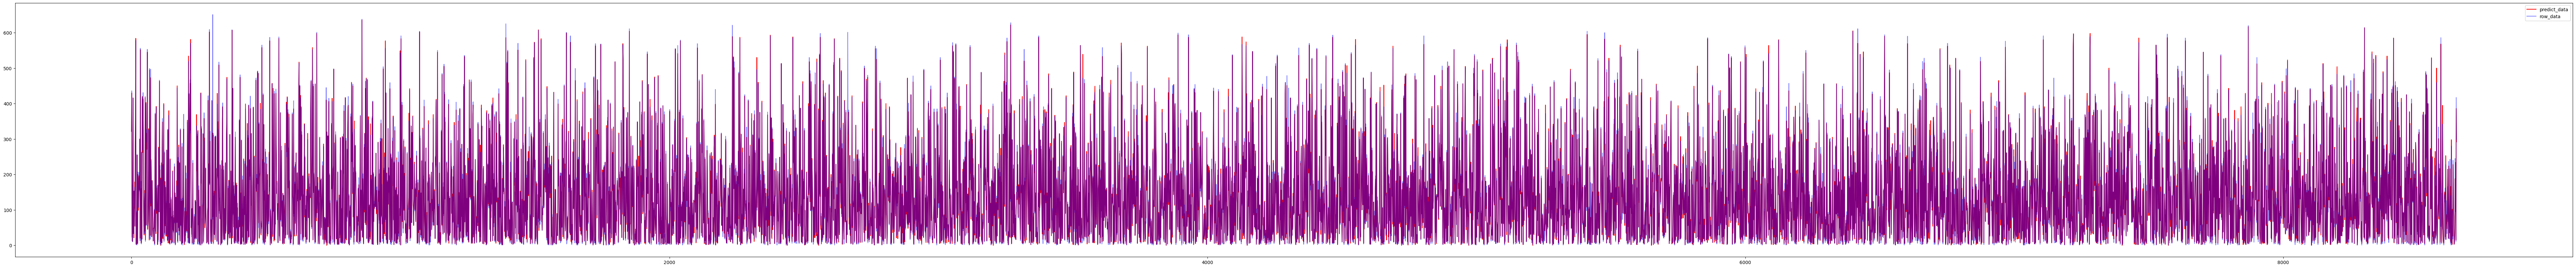

In [9]:
plt.figure(figsize=(100,10))
plt.plot(range(0,len(checked)),checked, color="r", label="predict_data")
plt.plot(range(0, len(x)), x, color="b", label="row_data", alpha=0.5)
plt.legend()
plt.show()

274/274 [==============================] - 1s 5ms/step


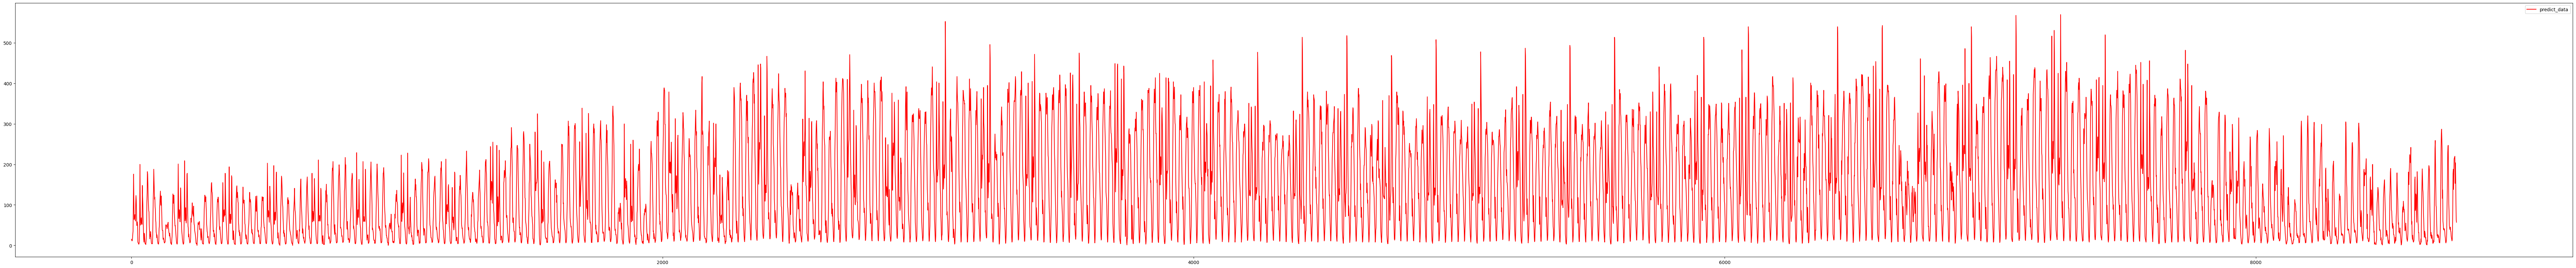

In [18]:
tokyo_predicted = model.predict(tokyo_y)
tokyo_checked = np.array([check(i) for i in tokyo_predicted]).reshape(tokyo_predicted.shape[0],1)
plt.figure(figsize=(100,10))
plt.plot(range(0,len(tokyo_checked)),tokyo_checked, color="r", label="predict_data")
plt.legend()
plt.show()

In [19]:
tokyo_data3 = np.hstack((tokyo_data,tokyo_checked))
np.savetxt("tokyo_predicted.csv",tokyo_data3,delimiter=",",fmt="%s")